In [1]:
# Generate dataset
import numpy as np
def data_generator(dim0, dim1, dim2, clusterSize, sigma, s):
        T  = np.zeros((dim0, dim1, dim2))
        r = 0 # counter
        for s in range(s):   # suppose that we have two clusters
            u, v, w = np.zeros((dim0)), np.zeros((dim1)), np.zeros((dim2))
            tensorSignal = np.zeros((dim0, dim1, dim2))
            for i in range(r, r + clusterSize):
                v[i] = 1/np.sqrt(clusterSize)
                u[i] = 1/np.sqrt(clusterSize)
                w[i] = 1/np.sqrt(clusterSize)
            for i in range(dim0):
                for j in range(dim1):
                    for k in range(dim2):
                        tensorSignal[i,j,k] = sigma * v[i]*u[j]*w[k]
            T += tensorSignal
            r += max(clusterSize, clusterSize, clusterSize)
        return T + np.random.normal(0, 1,  size= (dim0, dim1, dim2))

In [2]:
from mlxtend.preprocessing import standardize
def normed_and_covariance(M):
        M = standardize(M)  # by column by default
        M = (M.T).dot(M)
        return M

In [3]:
def rayleigh_power_iteration(A, num_simulations: int):
    b_k = np.random.rand(A.shape[1])          # initialization
    for _ in range(num_simulations):
        b_k1 = np.dot(A, b_k)    # compute A times b_k
        b_k = b_k1 / np.linalg.norm(b_k1)    # make the new value of  b_k a unit vector
    eig_value = np.dot(np.dot(b_k.T, A),b_k)         # compute the eigenvalue
    return  eig_value, b_k

In [4]:
# We only focus on one mode
import scipy.linalg as la
from numpy import linalg as LA
from sklearn.metrics import rand_score as ari
from sklearn.cluster import HDBSCAN

def mschdbscan(data, with_rayleigh, min_elt=4): # data is a third-order tensor
        dim0, dim1, dim2 = data.shape
        eigen_matrix = np.zeros((dim0, dim2))  # each row is the product of eigenvalue and eigenvector
        # the eigenvalue and eigenvector of each slices 
        eigen_max = 0
        for k in range(dim0):
            frontal =  normed_and_covariance(data[k,:,:])
            if (with_rayleigh == True):
                w, v = rayleigh_power_iteration(frontal, 100)
            else :
                w, v = la.eig(frontal)
                a = np.argmax(w.real)
                w, v = w[a].real, v[:,a].real
            eigen_matrix[k,:] = w.real * v.real
            if (eigen_max < w.real):
                eigen_max = w.real  
        eigen_matrix = eigen_matrix / eigen_max
        hdb = HDBSCAN(min_cluster_size=min_elt, metric='l2').fit(eigen_matrix)
        groups_label = hdb.labels_
        return  hdb.labels_               

In [5]:
def SliceRMSE(data, label):
    uniq = set(label)
    rmse = []
    for j in uniq:
            tmp = []
            mat = np.zeros((data[0,:,:].shape))
            for i in range(data.shape[0]): 
                if label[i] == j:
                    tmp.append(i)
            for i in tmp:
                mat = mat + data[i,:,:]   # Mean of the slices
            mean = mat / len(tmp)
            rmse.append( ( j, np.sqrt( np.sum([( LA.norm(mean - data[i,:,:], "fro") )**2 for i in tmp]) / len(tmp) )) )
            #rmse.append( (j, np.max([ LA.norm(data[a,:,:]-data[b,:,:], "fro") for idx, a in enumerate(tmp) for b in tmp[idx+1:]])))       
    return rmse

In [6]:
# Tucker + k-means
from tensorly.decomposition import tucker
def tuckerKMeans(data, k):
    core, factors = tucker(data, rank=[k, k, k])
    mat = factors[0]   # The required factor matrix
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init = 10, random_state=0).fit(mat)        # Apply k-means
    return kmeans.labels_

In [7]:
# TBM 
# Update the mode-k membership matrices
import tensorly as tl
from tensorly import unfold
from sklearn.cluster import KMeans
def updateMembershipMatrix(data, core, dataShape, R, matrices):
        for k in range(3):
            # select a random index in one dimension
            a = np.random.randint(0, dataShape[k])
            # for a in range(self.dataShape[k]):   # this is to test all elements of the tensor
            # we focus in the membership matrix M_k
            # Min is a list on which we take the min for the cluster label M_k(a)
            Min = []
            for r in range(R[k]):
                # Construction of the set I_k
                S = 0
                if (k == 0 ):
                    for i1, i2 in itertools.product(range(dataShape[1]), range(dataShape[2])):
                        ic1 = np.nonzero(matrices[1][i1,:])[0][0]
                        ic2 = np.nonzero(matrices[2][i2,:])[0][0]
                        S = S + (core[r,ic1,ic2] - data[a,i1,i2])**2
                            
                elif(k == 1):
                    for i0, i2 in itertools.product(range(dataShape[0]), range(dataShape[2])):
                        ic0 = np.nonzero(matrices[0][i0,:])[0][0]
                        ic2 = np.nonzero(matrices[2][i2,:])[0][0]
                        S = S + (core[ic0,r,ic2] - data[i0,a,i2])**2
                        
                elif( k == 2):
                    for i0, i1 in itertools.product(range(dataShape[0]), range(dataShape[1])):
                        ic0 = np.nonzero(matrices[0][i0,:])[0][0]
                        ic1 = np.nonzero(matrices[1][i1,:])[0][0]
                        S = S + (core[ic0,ic1,r] - data[i0,i1,a])**2  
                Min.append(S)   
            # new cluster : cluster index who has S minimal
            new = np.argmin(Min)
            # update the Membership matrix M_k(a)
            matrices[k][a,:] = np.zeros(( R[k] ))     
            matrices[k][a,new] = 1
        return matrices

In [8]:
# Update the core tensor C
def updateCoreTensor(data, dataShape, matrices, R ):
            core = np.zeros((R[0], R[1], R[2] ))
            for i in itertools.product(range(R[0]), range(R[1]), range(R[2])):                           
                r0, r1, r2 = i    
                # Find the M^-1
                MInvr0 = np.nonzero(matrices[0][:,r0])[0].tolist()  # return 
                MInvr1 = np.nonzero(matrices[1][:,r1])[0].tolist()
                MInvr2 = np.nonzero(matrices[2][:,r2])[0].tolist()
                nr = len(MInvr0) * len(MInvr1) * len(MInvr2)                    
                # sum
                A = data[MInvr0,:,:]
                A = A[:, MInvr1,:]
                A = A[:, :, MInvr2]
                core[r0, r1, r2] =  np.sum(A) / nr  
            return core

In [9]:
 def get_cluster(matrices, R):
        C = []
        for c in range(3):
            cluster = [0 for _ in range(len(matrices[c][:,0]))]
            for k in range(R[c]):
                for i in range(len(cluster)):
                    if ( matrices[c][i,k] == 1 ):
                        cluster[i] = k
            C.append(cluster)
        return C   # each element of C represent the mode_k cluster

In [10]:
# Multi Slice Clusteirng
import multiSliceClustering as msc
def mscMethod(data, eps):
    res = msc.MSC(data, e_ = eps)
    I  = res.get_cluster()
    estimation = [[1 if h in I[0] else 0 for h in range(data.shape[0])],[1 if h in I[1] else 0 for h in range(data.shape[1])],[1 if h in I[2] else 0 for h in range(data.shape[2])]]
    return estimation[0]

In [11]:
# Affichage
import matplotlib.pyplot as plt
def plotImage(hdbscanT, tbmT, mscT, tuckerT):
    sigma = [i[0] for i in hdbscanT]
    ari_hdbscanT_mean = [i[1] for i in hdbscanT]
    ari_hdbscanT_std = [i[2] for i in hdbscanT]
    ari_tbm_mean = [i[1] for i in tbmT]
    ari_tbm_std = [i[2] for i in tbmT]
    ari_msc_mean = [i[1] for i in mscT]
    ari_msc_std = [i[2] for i in mscT]
    ari_tucker_mean = [i[1] for i in tuckerT]
    ari_tucker_std = [i[2] for i in tuckerT]
    
    plt.errorbar(sigma, ari_msc_mean, ari_msc_std, linestyle='None', marker='')
    plt.plot(sigma,ari_msc_mean, label="MSC")
    
    plt.errorbar(sigma, ari_tucker_mean, ari_tucker_std, linestyle='None', marker='')
    plt.plot(sigma, ari_tucker_mean, label="Tucker+k-means")
    
    plt.errorbar(sigma, ari_tbm_mean, ari_tbm_std, linestyle='None', marker='')
    plt.plot(sigma, ari_tbm_mean, label="TBM")
    
    plt.errorbar(sigma, ari_hdbscanT_mean, ari_hdbscanT_std, linestyle='None', marker='')
    plt.plot(sigma, ari_hdbscanT_mean, label="HDBSCAN-Tensor")
    plt.xlabel("weight of the signal tensor", fontsize=14)
    plt.ylabel("adjusted rand-index", fontsize=14)
    plt.legend( fontsize=14 )
    plt.savefig('./image/image.png')

In [12]:
# TBM
import numpy as np
from tensorly.base import unfold
from sklearn.cluster import KMeans
import itertools
from tensorly.tenalg import mode_dot
from tensorly import norm

def tbm(data, R, simulations):
    dataShape = data.shape
    matrices = []
    for i in range(3):
        A = unfold(data, i)   # mode-i unfolding
        kmeans = KMeans(n_clusters=R[i], init='k-means++', max_iter=100, n_init = 10, random_state=0)
        matrices.append(kmeans.fit_predict(A).tolist())   # cluster structured as a list
    # Build the membership matrices from the result of the k-means
    for i in range(3):
        M = np.zeros( (dataShape[i], R[i]) )   
        for j, u in enumerate( matrices[i]):
            M[j,u] = 1        
        matrices[i] = M
    for _ in range(simulations):
        core = updateCoreTensor(data, dataShape, matrices, R)
        matrices = updateMembershipMatrix(data, core, dataShape, R, matrices)
    res = get_cluster(matrices, R)
    return res[0]

MSCHDBSCAN  [0.4989387755102041, 0.5198367346938775, 0.5463673469387755, 0.7009795918367348, 0.763265306122449, 0.7508571428571429, 0.818204081632653, 0.9000816326530611, 0.9684081632653061, 0.9915102040816327, 1.0, 1.0]
 TBM  [0.5275102040816326, 0.5524897959183673, 0.5986122448979592, 0.6817142857142857, 0.765061224489796, 0.8753469387755102, 0.9416326530612246, 0.9661224489795919, 0.9936326530612245, 1.0, 1.0, 1.0]
 MSC  [0.4691428571428572, 0.5106938775510205, 0.5840816326530611, 0.5787755102040816, 0.6554285714285715, 0.6140408163265306, 0.712734693877551, 0.7088979591836735, 0.7703673469387755, 0.7315102040816327, 0.8251428571428571, 0.792]
Tucker k means  [0.794204081632653, 0.9648979591836735, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


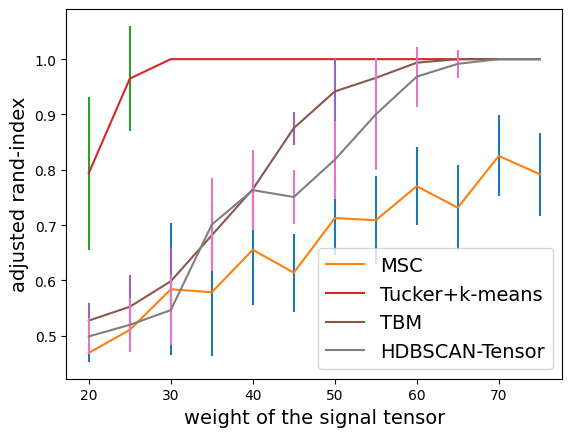

In [13]:
# two clusters
ari_mschdbscan, ari_tbm, ari_tucker, ari_msc = [], [], [], []
for sigma in range (20, 80, 5): 
    dim0, dim1, dim2 = 50, 50, 50
    clusterSize = 10
    true_label=[0 for i in range(clusterSize)]+[1 for i in range(clusterSize)]+[2 for i in range(dim0 - 2*clusterSize)]
    res_mschdbscan, res_tucker, res_tbm, res_msc = [], [], [], []
    for _ in range(10):
        data = data_generator(dim0, dim1, dim2, clusterSize, sigma, 2)
        res_mschdbscan.append( ari(true_label, mschdbscan(data, with_rayleigh=True, min_elt=3)) )
        res_tucker.append( ari(true_label, tuckerKMeans(data, 3)) )
        res_tbm.append( ari(true_label, tbm(data, [3,3,3], 5)) )
        res_msc.append( ari(true_label, mscMethod(data, 0.0006)) )
    # (sigma, mean of the ari, std of the ari)
    ari_mschdbscan.append( ( sigma, np.mean(res_mschdbscan), np.std(res_mschdbscan) ) )
    ari_tbm.append( ( sigma, np.mean(res_tbm), np.std(res_tbm) ) )
    ari_tucker.append( ( sigma, np.mean(res_tucker), np.std(res_tucker) ) )
    ari_msc.append( ( sigma, np.mean(res_msc), np.std(res_msc) ) )
print("MSCHDBSCAN ", [i[1] for i in ari_mschdbscan])
print(" TBM ", [i[1] for i in ari_tbm])
print(" MSC ", [i[1] for i in ari_msc] )
print("Tucker k means ", [i[1] for i in ari_tucker])
plotImage(ari_mschdbscan, ari_tbm, ari_msc, ari_tucker)

# REAL DATA

In [13]:
# Real data
from scipy.io import loadmat
data = loadmat('./data/flow_injection/Flow_Injection/fia.mat')
data = data['X']
data = np.reshape(data, (12,100,89), order="F")
data = np.moveaxis(data, -1, 0)  

In [14]:
label = mschdbscan(data, with_rayleigh=True, min_elt=7)
res = SliceRMSE(data, label)
print("HDBSCAN Tensor ", res, " mean = ", np.mean([i[1] for i in res if i[0] != -1]) )

HDBSCAN Tensor  [(0, 0.8707251980085471), (1, 1.2416459267316717), (-1, 2.3950325923367135)]  mean =  1.0561855623701093


In [15]:
label = tuckerKMeans(data, 3)
res =  SliceRMSE(data, label)
print("Tucker k means ", res ," mean = ", np.mean([i[1] for i in res if i[0] != -1]) )

Tucker k means  [(0, 0.9064407473962829), (1, 1.7762111670640053), (2, 1.5271707031001118)]  mean =  1.4032742058534666


In [16]:
# we take the number of the cluster the result given by the MSCHDBSCAN
label = tbm(data, R=(3,3,3), simulations=3)
res = SliceRMSE(data, label)
print("TBM ", res, " mean = ", np.mean([i[1] for i in res if i[0] != -1]))

TBM  [(0, 1.0605803899893873), (1, 1.1080680073411335), (2, 1.289371344897378)]  mean =  1.1526732474092996


In [17]:
# MSC
label = mscMethod(data, eps = 0.00006)
res = SliceRMSE(data, label)
print(" MSC ", res, " mean = ", np.mean([i[1] for i in res if i[0] != -1]))

 MSC  [(0, 2.2958700905410514), (1, 0.35534088280966647)]  mean =  1.325605486675359
